In [20]:
import numpy as np
import pandas as pd

In [21]:
class Mode:
    TRAINING = 0
    EVALUATION = 1
    
class NeuralLayer:
    def __init__(self):
        self.input_data = None
        self.output_data = None
        self.current_mode = Mode.TRAINING
        
    def forward(self, inputs):
        raise NotImplementedError("The forward pass must be implemented by subclasses.")
        
    def backward(self, out_grad):
        raise NotImplementedError("The backward pass must be implemented by subclasses.")
        
    def parameters(self):
        return None
    
    def set_mode(self, mode):
        self.current_mode = mode

In [22]:
class FullyConnectedLayer(NeuralLayer):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim + output_dim))
        self.bias = np.zeros(output_dim)
        
    def forward(self, inputs):
        self.input_data = inputs
        return np.dot(inputs, self.weight) + self.bias
        
    def backward(self, out_grad):
        self.weight_gradient = np.dot(self.input_data.T, out_grad)
        self.bias_gradient = np.sum(out_grad, axis=0)
        return np.dot(out_grad, self.weight.T)
    
    def parameters(self):
        return (
            {'weights': self.weight, 'biases': self.bias},
            {'weights': self.weight_gradient, 'biases': self.bias_gradient}
        )

In [23]:
class ReLU(NeuralLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs):
        self.input_data = inputs
        return np.maximum(0, inputs)
    
    def backward(self, out_grad):
        return out_grad * (self.input_data > 0)
        
class SoftMax(NeuralLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs):
        shifted_inputs = inputs - np.max(inputs, axis=1, keepdims=True)
        exps = np.exp(shifted_inputs)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def backward(self, out_grad):
        softmax_x = self.forward(out_grad)
        return softmax_x * (1 - softmax_x)

In [24]:
class Dropout(NeuralLayer):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.mask = None
        
    def forward(self, inputs):
        if self.current_mode == Mode.TRAINING:
            self.mask = (np.random.rand(*inputs.shape) > self.p) / (1 - self.p)
            return inputs * self.mask
        return inputs
    
    def backward(self, out_grad):
        return out_grad * self.mask if self.mask is not None else out_grad

In [25]:
class BatchNormalizationLayer(NeuralLayer):
    def __init__(self, input_dim, momentum=0.9, epsilon=1e-5):
        super().__init__()
        self.gamma = np.ones(input_dim)
        self.beta = np.zeros(input_dim)
        self.input = None
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = np.zeros(input_dim)
        self.running_var = np.ones(input_dim)
        
    def forward(self, input_data):
        self.input = input_data
        if self.current_mode == Mode.TRAINING:
            self.batch_mean = np.mean(input_data, axis=0)
            self.batch_var = np.var(input_data, axis=0)
            
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
            
            self.x_centered = input_data - self.batch_mean
            self.std = np.sqrt(self.batch_var + self.epsilon)
            self.x_norm = self.x_centered / self.std
            
            out = self.gamma * self.x_norm + self.beta
        else:
            x_norm = (input_data - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * x_norm + self.beta
        return out
        
    def backward(self, output_grad):
        N = output_grad.shape[0]
        std_inv = 1. / self.std
        self.beta_grad = np.sum(output_grad, axis=0)
        self.gamma_grad = np.sum(output_grad * self.x_norm, axis=0)
        
        dx_norm = output_grad * self.gamma
        dvar = np.sum(dx_norm * self.x_centered * -0.5 * std_inv**3, axis=0)
        dmean = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2 * self.x_centered, axis=0)
        
        input_grad = dx_norm * std_inv + dvar * 2 * self.x_centered / N + dmean / N
        return input_grad
        
    def learnable_params(self):
        return (
            {'gamma': self.gamma, 'beta': self.beta}, 
            {'gamma': self.gamma_grad, 'beta': self.beta_grad}
        )

In [26]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def update(self, layers):
        raise NotImplementedError("Subclasses must implement apply_gradients.")
        
class Adam(Optimizer):
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1, self.beta2 = beta1, beta2
        self.epsilon = epsilon
        self.step_count = 0
        self.moment1 = []
        self.moment2 = []
        
    def _initialize_moments(self, layer_params):
        for params in layer_params:
            self.moment1.append({param: np.zeros_like(val) for param, val in params.items()})
            self.moment2.append({param: np.zeros_like(val) for param, val in params.items()})
            
    def update(self, layers):
        param_layers = [layer for layer in layers if layer.parameters() is not None]
        
        if not self.moment1 and not self.moment2:
            self._initialize_moments([layer.parameters()[0] for layer in param_layers])
            
        self.step_count += 1
        lr_t = self.learning_rate * np.sqrt(1 - self.beta2**self.step_count) / (1 - self.beta1**self.step_count)
        
        for i, layer in enumerate(param_layers):
            params, grads = layer.parameters()
            for param in params:
                self.moment1[i][param] = self.beta1 * self.moment1[i][param] + (1 - self.beta1) * grads[param]
                self.moment2[i][param] = self.beta2 * self.moment2[i][param] + (1 - self.beta2) * grads[param]**2
                params[param] -= lr_t * self.moment1[i][param] / (np.sqrt(self.moment2[i][param]) + self.epsilon)

In [27]:
class CrossEntropyLoss():
    def function(self, y_true, y_pred, epsilon=1e-8):
        return -np.mean(y_true * np.log(y_pred + epsilon))
        
    def derivative(self, y_true, y_pred):
        return y_pred - y_true

In [28]:
class NeuralNetwork:
    def __init__(self, name):
        self.layers = []
        self.name = name
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
        
    def set_mode(self, mode):
        for layer in self.layers:
            layer.set_mode(mode)
            
    def backward(self, output_grad):
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)

In [29]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
target_transform = transforms.Lambda(lambda y: np.eye(10, dtype=np.float32)[y])
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform, target_transform=target_transform
)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform, target_transform=target_transform
)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=False)

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def train_one_epoch(model, optimizer, train_loader, loss):
    model.set_mode(Mode.TRAINING)
    train_loss, y_pred_all, y_true_all = 0.0, [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.numpy(), y_batch.numpy()
        y_pred = model.forward(X_batch)
        loss_value = loss.function(y_batch, y_pred)
        train_loss += loss_value * y_batch.shape[0]
        grad = loss.derivative(y_batch, y_pred)
        model.backward(grad)
        optimizer.update(model.layers)
        y_pred_all.append(y_pred)
        y_true_all.append(y_batch)
    y_pred_all, y_true_all = np.concatenate(y_pred_all), np.concatenate(y_true_all)
    train_acc = accuracy_score(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
    return train_loss / len(train_loader), train_acc


In [31]:
def evaluate(model, val_loader, loss):
    model.set_mode(Mode.EVALUATION)
    val_loss, y_pred_all, y_true_all = 0.0, [], []
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.numpy(), y_batch.numpy()
        y_pred = model.forward(X_batch)
        val_loss += loss.function(y_batch, y_pred) * y_batch.shape[0]
        y_pred_all.append(y_pred)
        y_true_all.append(y_batch)
    y_pred_all, y_true_all = np.concatenate(y_pred_all), np.concatenate(y_true_all)
    val_acc = accuracy_score(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
    val_f1 = f1_score(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1), average='macro')
    return val_loss / len(val_loader), val_acc, val_f1, y_pred_all, y_true_all


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(train_losses, label='train')
    axs[0].plot(val_losses, label='val')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(train_accs, label='train')
    axs[1].plot(val_accs, label='val')
    axs[1].set_title('Accuracy')
    axs[1].legend()
    plt.show()


In [33]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

In [34]:
best_model = None
best_val_f1 = 0

In [47]:
def get_model1():
    model1 = NeuralNetwork(name='model_1')
    model1.add_layer(FullyConnectedLayer(784, 512))
    model1.add_layer(ReLU())
    model1.add_layer(Dropout(0.5))
    model1.add_layer(BatchNormalizationLayer(512))
    model1.add_layer(FullyConnectedLayer(512, 10))
    model1.add_layer(SoftMax())
    return model1

Epoch 1/10 - Train Loss: 161.7971, Acc: 0.7376 | Val Loss: 109.6232, Acc: 0.8243, F1: 0.8218
Epoch 2/10 - Train Loss: 104.6542, Acc: 0.8317 | Val Loss: 93.7579, Acc: 0.8514, F1: 0.8522
Epoch 3/10 - Train Loss: 93.1811, Acc: 0.8504 | Val Loss: 87.2169, Acc: 0.8647, F1: 0.8657
Epoch 4/10 - Train Loss: 88.6103, Acc: 0.8576 | Val Loss: 85.1769, Acc: 0.8614, F1: 0.8629
Epoch 5/10 - Train Loss: 85.5803, Acc: 0.8621 | Val Loss: 83.1632, Acc: 0.8699, F1: 0.8693
Epoch 6/10 - Train Loss: 81.9579, Acc: 0.8678 | Val Loss: 82.0762, Acc: 0.8710, F1: 0.8712
Epoch 7/10 - Train Loss: 80.6714, Acc: 0.8703 | Val Loss: 78.1531, Acc: 0.8768, F1: 0.8774
Epoch 8/10 - Train Loss: 79.1015, Acc: 0.8731 | Val Loss: 76.4279, Acc: 0.8766, F1: 0.8777
Epoch 9/10 - Train Loss: 78.6228, Acc: 0.8737 | Val Loss: 74.9725, Acc: 0.8800, F1: 0.8809
Epoch 10/10 - Train Loss: 76.6426, Acc: 0.8749 | Val Loss: 76.8708, Acc: 0.8746, F1: 0.8742


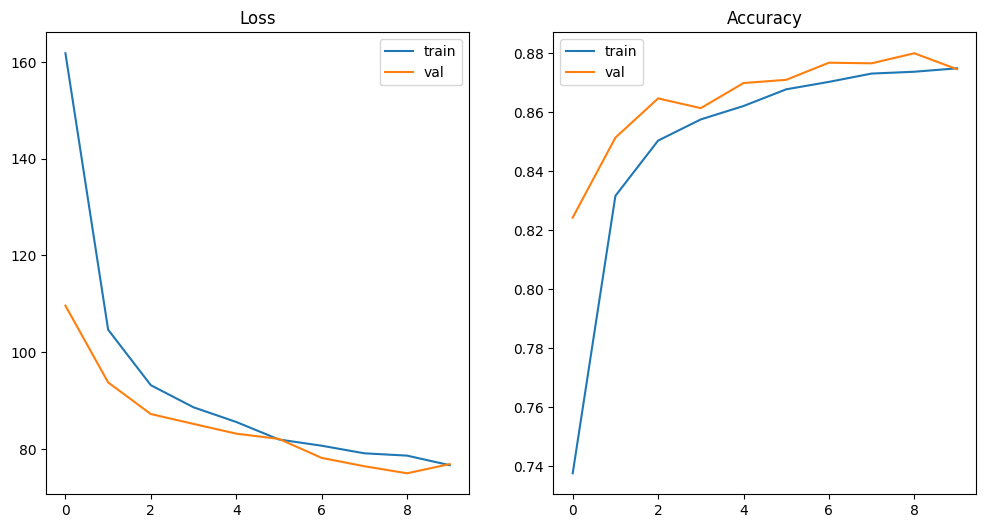

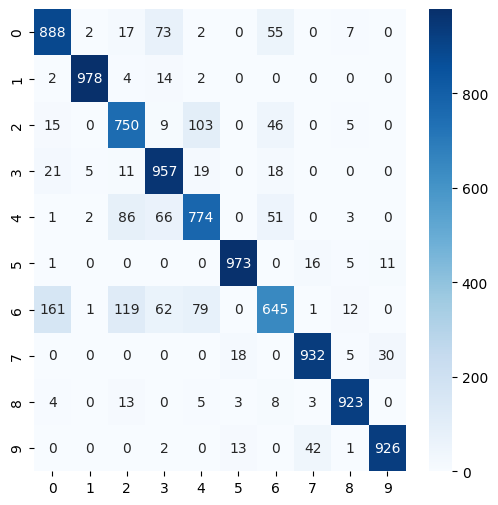

Epoch 1/10 - Train Loss: 159.0745, Acc: 0.7432 | Val Loss: 112.6173, Acc: 0.8306, F1: 0.8300
Epoch 2/10 - Train Loss: 102.1264, Acc: 0.8357 | Val Loss: 93.8919, Acc: 0.8542, F1: 0.8559
Epoch 3/10 - Train Loss: 90.7694, Acc: 0.8554 | Val Loss: 87.9580, Acc: 0.8571, F1: 0.8580
Epoch 4/10 - Train Loss: 86.9175, Acc: 0.8603 | Val Loss: 85.9357, Acc: 0.8602, F1: 0.8600
Early stopping triggered.


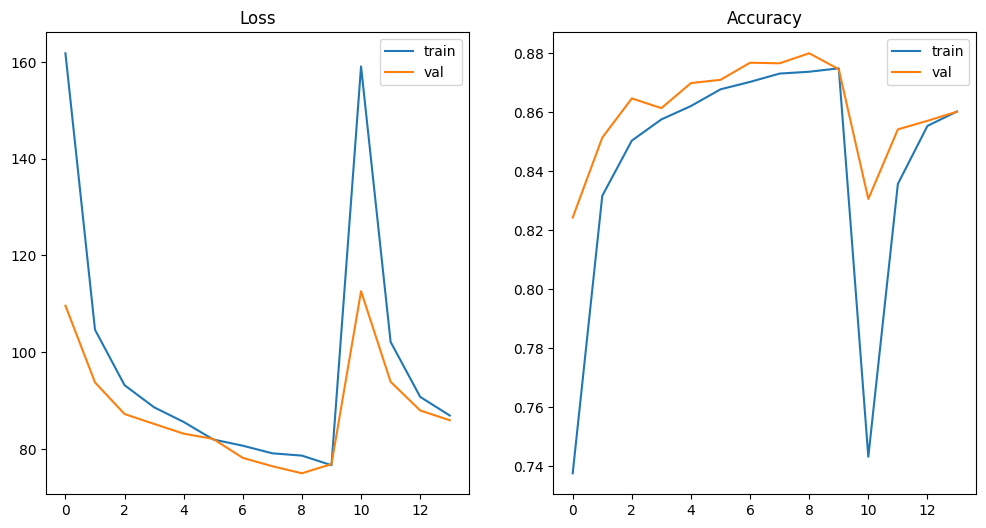

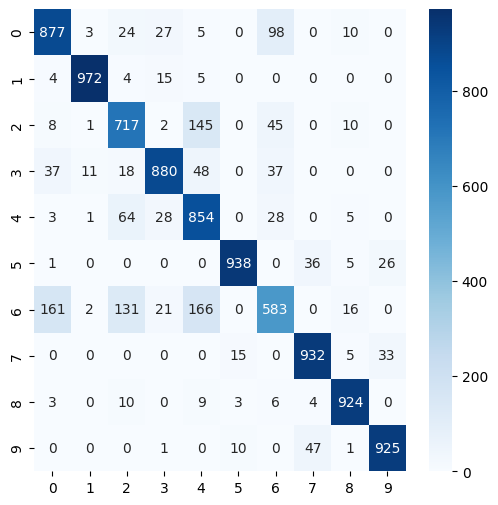

Epoch 1/10 - Train Loss: 175.5662, Acc: 0.7163 | Val Loss: 121.6837, Acc: 0.8255, F1: 0.8233
Early stopping triggered.


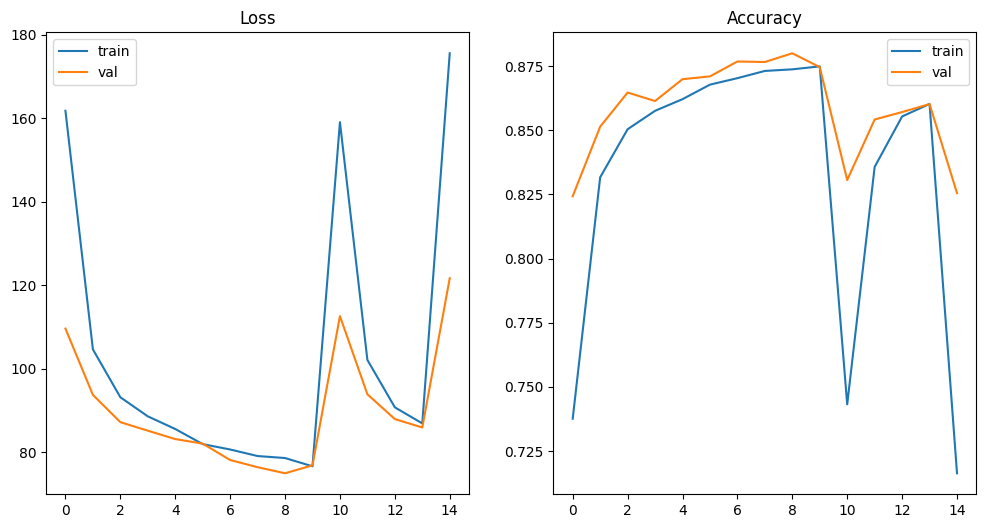

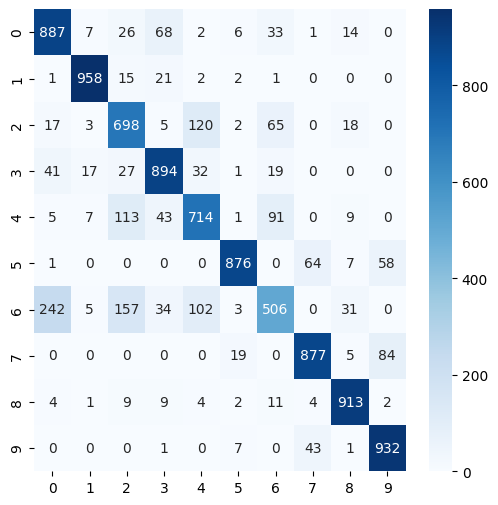

Epoch 1/10 - Train Loss: 199.1932, Acc: 0.6713 | Val Loss: 136.0131, Acc: 0.8071, F1: 0.8026
Early stopping triggered.


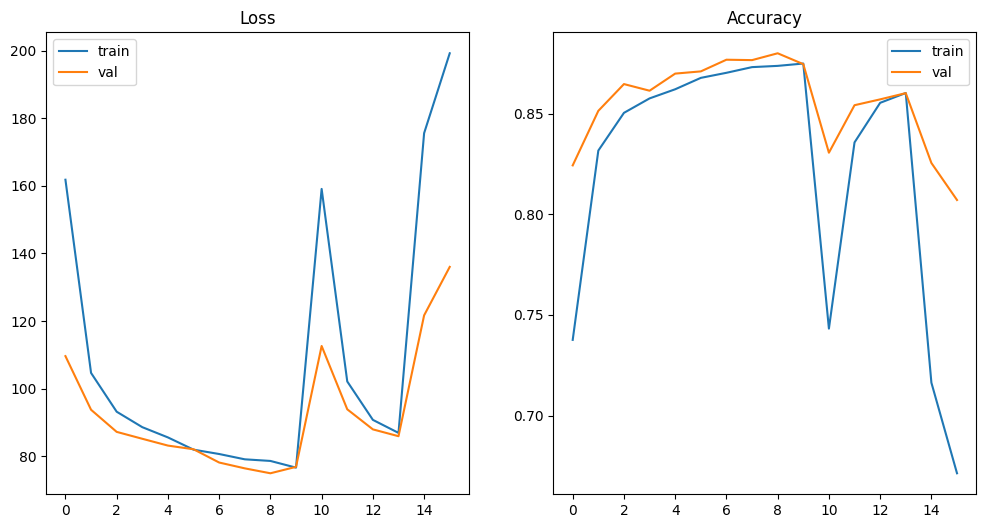

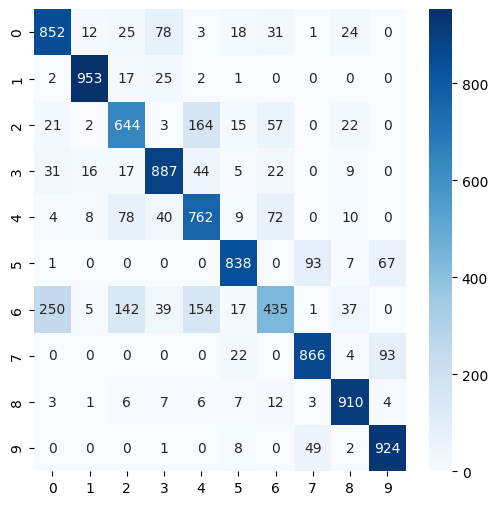

In [49]:
from tqdm import tqdm
import pickle
epochs = 10
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
base_lr = 0.005
loss = CrossEntropyLoss()
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for i in range(4):
    model = get_model1()
    optimizer = Adam(learning_rate=base_lr * 2**-i)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, loss)
        val_loss, val_acc, val_f1, y_pred_all, y_true_all = evaluate(model, val_loader, loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
            f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0 
        else:
            early_stop_counter += 1 
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
                
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model = model
        best_model_name = 'model_1'
        
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
    
best_model.set_mode(Mode.EVALUATION)

saved_params = {}
ctr = 0
for layer in best_model.layers:
    if isinstance(layer, FullyConnectedLayer):
        weights, biases = layer.weight, layer.bias
        saved_params[ctr] = {'weights': weights, 'biases': biases}
    elif isinstance(layer, BatchNormalizationLayer):
        running_mean, running_var = layer.running_mean, layer.running_var
        gamma, beta = layer.gamma, layer.beta
        saved_params[ctr] = {'running_mean': running_mean, 'running_var': running_var, 'gamma': gamma, 'beta': beta}
    else:
        saved_params[ctr] = None
    ctr += 1
    
with open('best_model.pkl', 'wb') as f:
    pickle.dump(saved_params, f)

In [50]:
def get_model2():
    model1 = NeuralNetwork(name='model_2')
    model1.add_layer(FullyConnectedLayer(784, 1024))
    model1.add_layer(ReLU())
    model1.add_layer(Dropout(0.5))
    model1.add_layer(BatchNormalizationLayer(1024))
    model1.add_layer(FullyConnectedLayer(1024, 10))
    model1.add_layer(SoftMax())
    return model1

Epoch 1/10 - Train Loss: 169.3852, Acc: 0.7289 | Val Loss: 109.6981, Acc: 0.8252, F1: 0.8236
Epoch 2/10 - Train Loss: 104.8635, Acc: 0.8301 | Val Loss: 95.2955, Acc: 0.8481, F1: 0.8469
Epoch 3/10 - Train Loss: 93.2083, Acc: 0.8492 | Val Loss: 86.8026, Acc: 0.8605, F1: 0.8611
Epoch 4/10 - Train Loss: 87.7518, Acc: 0.8581 | Val Loss: 83.5889, Acc: 0.8680, F1: 0.8673
Epoch 5/10 - Train Loss: 84.3159, Acc: 0.8635 | Val Loss: 82.9005, Acc: 0.8621, F1: 0.8653
Epoch 6/10 - Train Loss: 81.8762, Acc: 0.8678 | Val Loss: 81.1587, Acc: 0.8672, F1: 0.8675
Epoch 7/10 - Train Loss: 80.4290, Acc: 0.8695 | Val Loss: 83.0395, Acc: 0.8669, F1: 0.8668
Epoch 8/10 - Train Loss: 78.8149, Acc: 0.8711 | Val Loss: 79.0124, Acc: 0.8745, F1: 0.8761
Epoch 9/10 - Train Loss: 77.3962, Acc: 0.8752 | Val Loss: 76.4046, Acc: 0.8760, F1: 0.8780
Epoch 10/10 - Train Loss: 75.8220, Acc: 0.8765 | Val Loss: 76.1327, Acc: 0.8771, F1: 0.8780


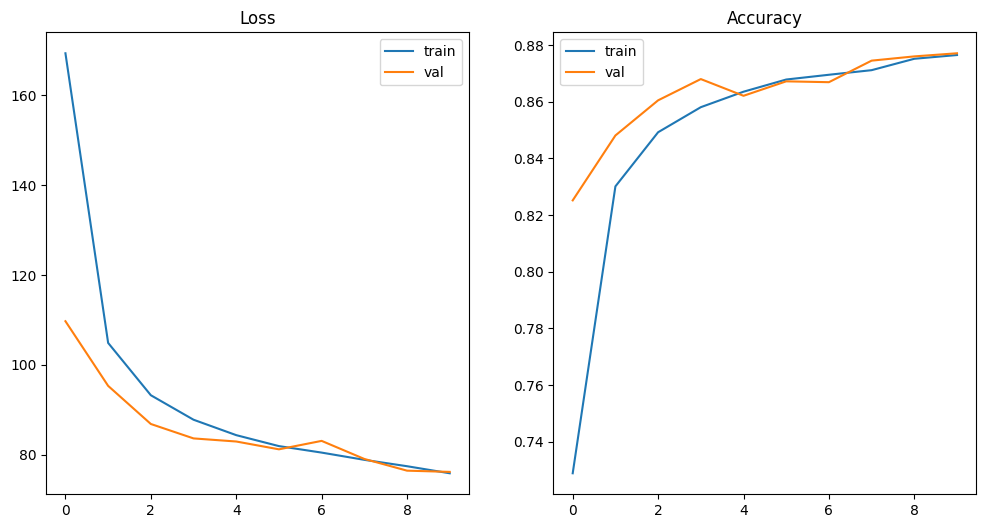

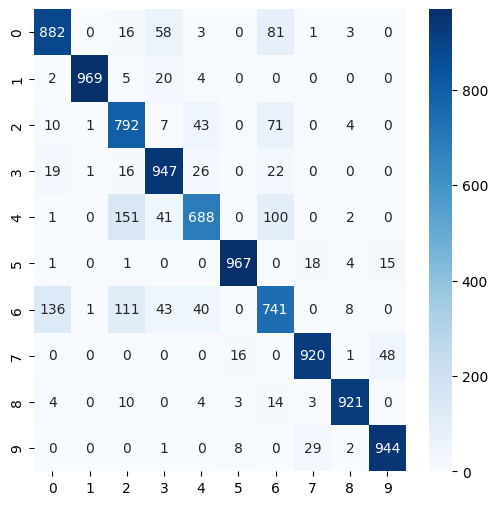

Epoch 1/10 - Train Loss: 157.6008, Acc: 0.7453 | Val Loss: 110.5034, Acc: 0.8286, F1: 0.8236
Epoch 2/10 - Train Loss: 99.2692, Acc: 0.8408 | Val Loss: 90.7772, Acc: 0.8573, F1: 0.8590
Epoch 3/10 - Train Loss: 88.9533, Acc: 0.8580 | Val Loss: 84.1495, Acc: 0.8597, F1: 0.8616
Epoch 4/10 - Train Loss: 83.4701, Acc: 0.8664 | Val Loss: 82.5547, Acc: 0.8714, F1: 0.8732
Epoch 5/10 - Train Loss: 79.8085, Acc: 0.8709 | Val Loss: 79.3009, Acc: 0.8712, F1: 0.8726
Early stopping triggered.


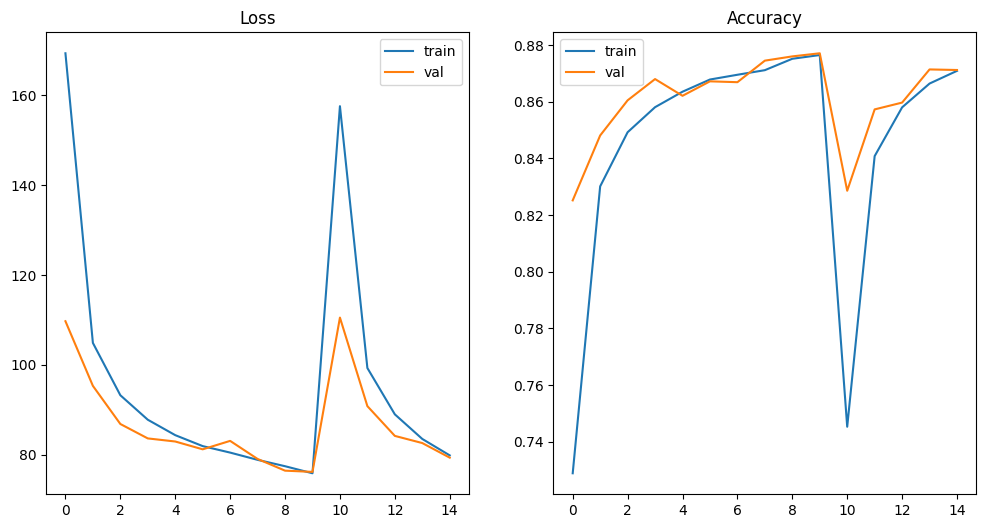

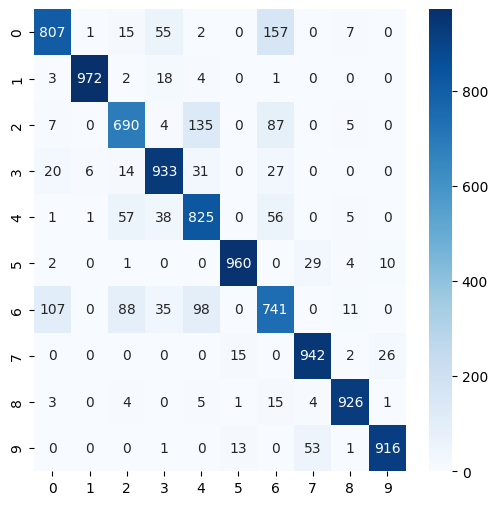

Epoch 1/10 - Train Loss: 157.0661, Acc: 0.7465 | Val Loss: 116.0707, Acc: 0.8327, F1: 0.8318
Early stopping triggered.


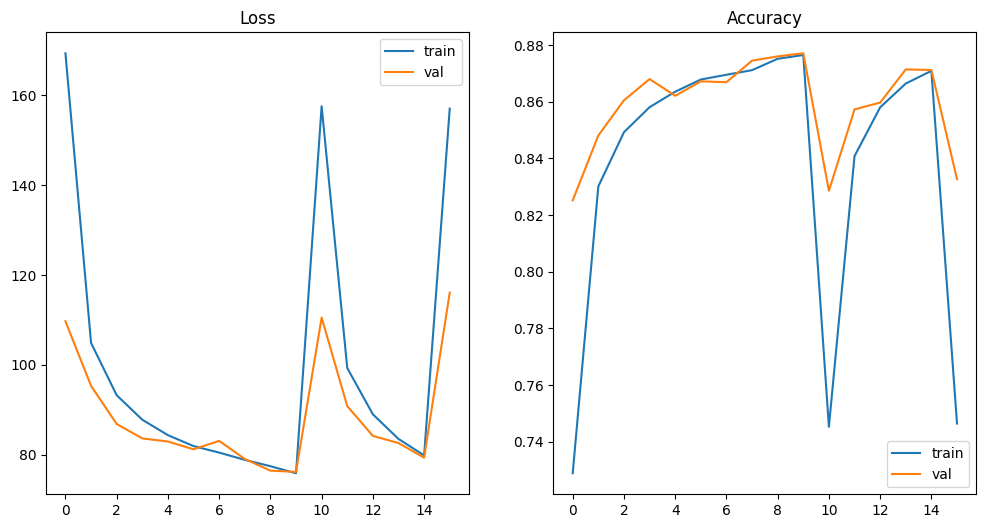

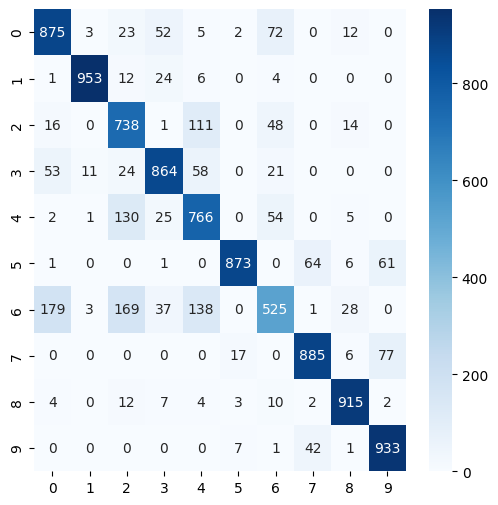

Epoch 1/10 - Train Loss: 169.8826, Acc: 0.7248 | Val Loss: 128.8199, Acc: 0.8143, F1: 0.8082
Early stopping triggered.


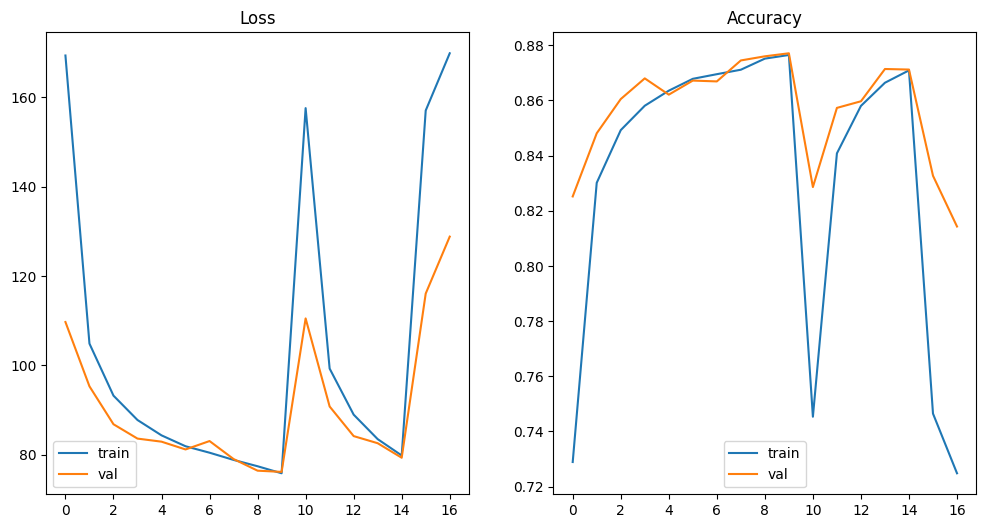

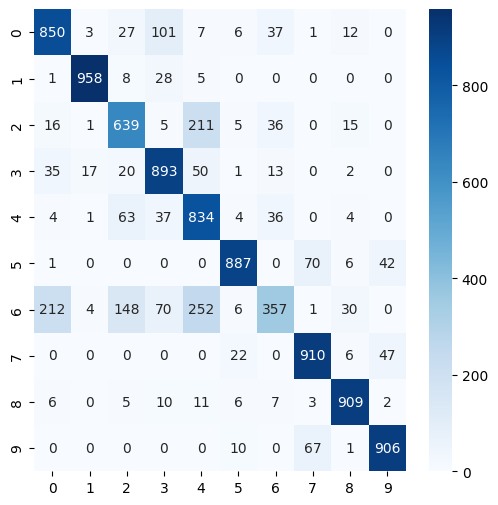

In [52]:
from tqdm import tqdm
import pickle
epochs = 10
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
base_lr = 0.005
loss = CrossEntropyLoss()
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for i in range(4):
    model = get_model2()
    optimizer = Adam(learning_rate=base_lr * 2**-i)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, loss)
        val_loss, val_acc, val_f1, y_pred_all, y_true_all = evaluate(model, val_loader, loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
            f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0 
        else:
            early_stop_counter += 1 
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
                
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model = model
        best_model_name = 'model_2'
        
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
    
best_model.set_mode(Mode.EVALUATION)

saved_params = {}
ctr = 0
for layer in best_model.layers:
    if isinstance(layer, FullyConnectedLayer):
        weights, biases = layer.weight, layer.bias
        saved_params[ctr] = {'weights': weights, 'biases': biases}
    elif isinstance(layer, BatchNormalizationLayer):
        running_mean, running_var = layer.running_mean, layer.running_var
        gamma, beta = layer.gamma, layer.beta
        saved_params[ctr] = {'running_mean': running_mean, 'running_var': running_var, 'gamma': gamma, 'beta': beta}
    else:
        saved_params[ctr] = None
    ctr += 1
    
with open('best_model.pkl', 'wb') as f:
    pickle.dump(saved_params, f)

In [53]:
def get_model3():
    model1 = NeuralNetwork(name='model_3')
    model1.add_layer(FullyConnectedLayer(784, 256))
    model1.add_layer(ReLU())
    model1.add_layer(Dropout(0.5))
    model1.add_layer(BatchNormalizationLayer(256))
    model1.add_layer(FullyConnectedLayer(256, 10))
    model1.add_layer(SoftMax())
    return model1

Epoch 1/10 - Train Loss: 171.6320, Acc: 0.7194 | Val Loss: 113.7773, Acc: 0.8145, F1: 0.8064
Epoch 2/10 - Train Loss: 111.1632, Acc: 0.8225 | Val Loss: 97.1221, Acc: 0.8491, F1: 0.8503
Epoch 3/10 - Train Loss: 99.4300, Acc: 0.8397 | Val Loss: 90.2841, Acc: 0.8557, F1: 0.8562
Epoch 4/10 - Train Loss: 94.4094, Acc: 0.8504 | Val Loss: 87.8465, Acc: 0.8626, F1: 0.8630
Epoch 5/10 - Train Loss: 89.3275, Acc: 0.8575 | Val Loss: 82.3010, Acc: 0.8665, F1: 0.8673
Epoch 6/10 - Train Loss: 86.8553, Acc: 0.8601 | Val Loss: 83.5576, Acc: 0.8671, F1: 0.8688
Epoch 7/10 - Train Loss: 84.9869, Acc: 0.8637 | Val Loss: 81.0524, Acc: 0.8712, F1: 0.8716
Epoch 8/10 - Train Loss: 82.6021, Acc: 0.8678 | Val Loss: 79.5715, Acc: 0.8732, F1: 0.8737
Epoch 9/10 - Train Loss: 81.1897, Acc: 0.8704 | Val Loss: 80.5718, Acc: 0.8715, F1: 0.8718
Epoch 10/10 - Train Loss: 80.9879, Acc: 0.8693 | Val Loss: 79.0118, Acc: 0.8755, F1: 0.8761


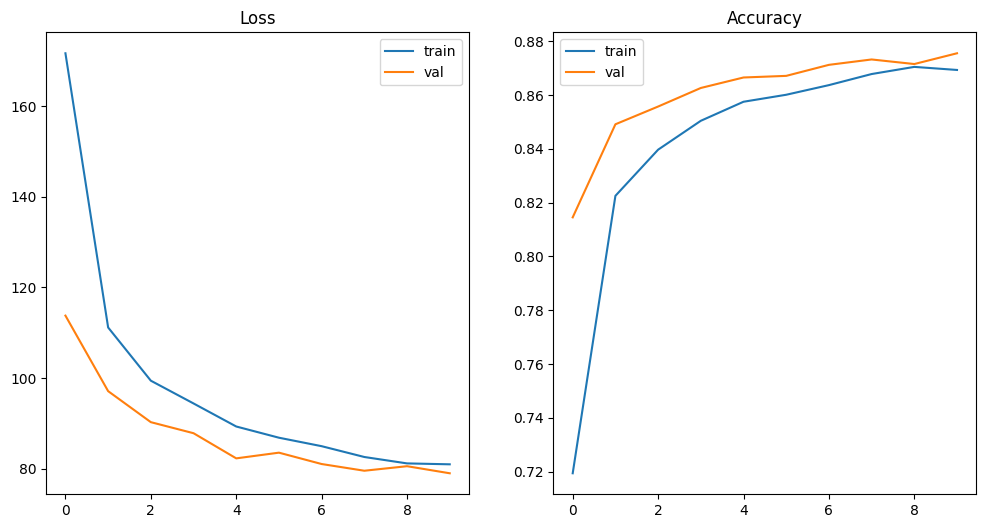

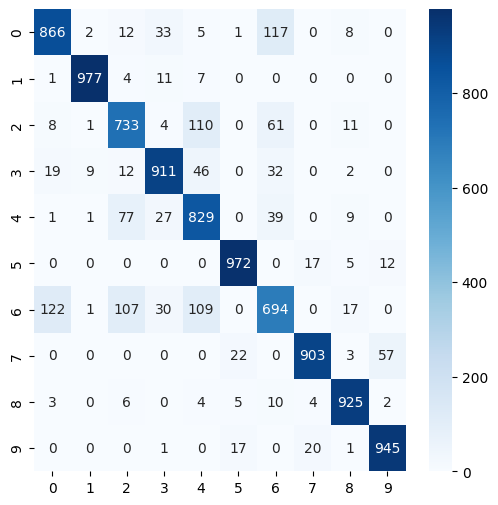

Epoch 1/10 - Train Loss: 175.6691, Acc: 0.7132 | Val Loss: 121.0554, Acc: 0.8104, F1: 0.8093
Epoch 2/10 - Train Loss: 109.9913, Acc: 0.8244 | Val Loss: 98.3781, Acc: 0.8446, F1: 0.8430
Epoch 3/10 - Train Loss: 99.0114, Acc: 0.8424 | Val Loss: 92.1531, Acc: 0.8514, F1: 0.8510
Epoch 4/10 - Train Loss: 92.5575, Acc: 0.8513 | Val Loss: 86.8177, Acc: 0.8653, F1: 0.8651
Epoch 5/10 - Train Loss: 88.7393, Acc: 0.8584 | Val Loss: 85.0961, Acc: 0.8598, F1: 0.8593
Early stopping triggered.


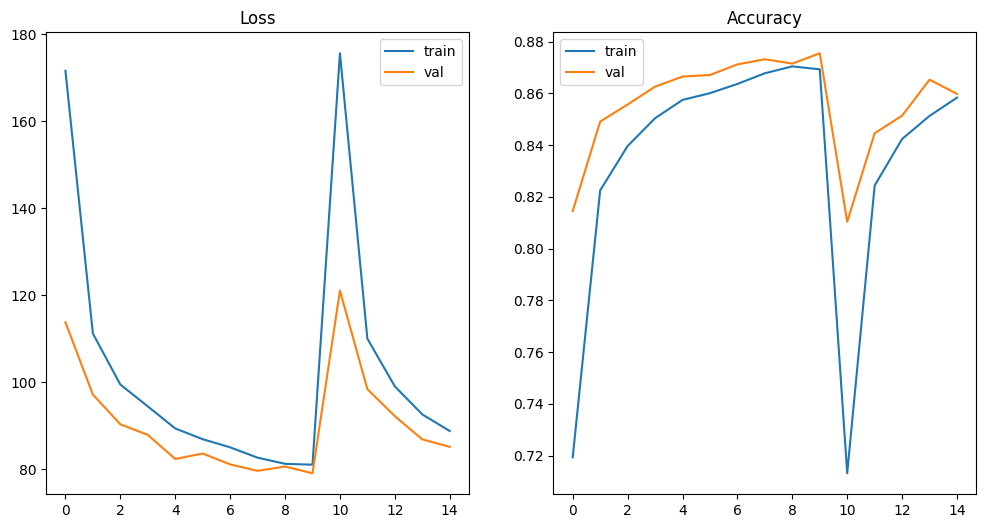

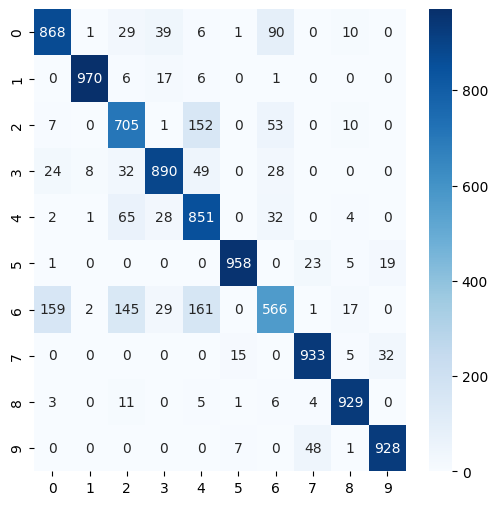

Epoch 1/10 - Train Loss: 191.0827, Acc: 0.6861 | Val Loss: 131.8190, Acc: 0.8108, F1: 0.8074
Early stopping triggered.


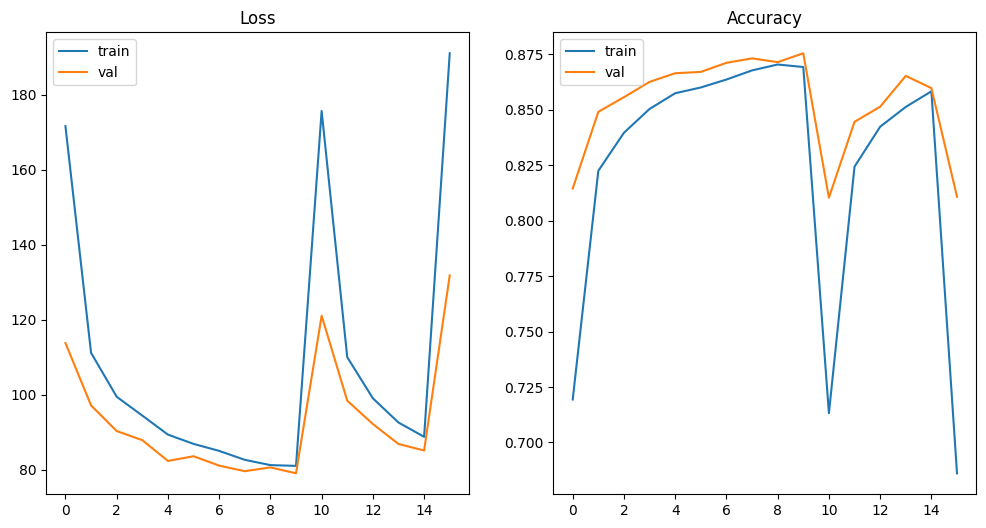

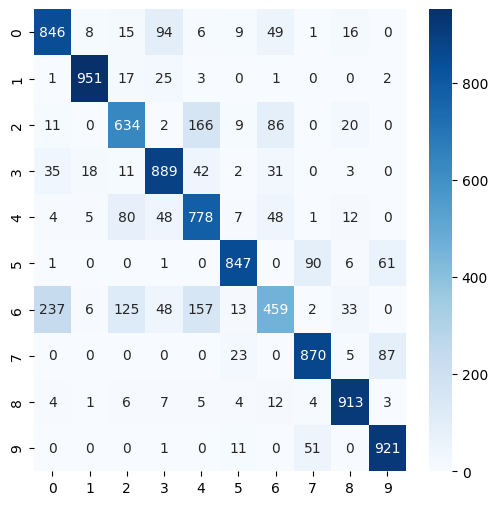

Epoch 1/10 - Train Loss: 235.7122, Acc: 0.6159 | Val Loss: 156.1241, Acc: 0.7662, F1: 0.7483
Early stopping triggered.


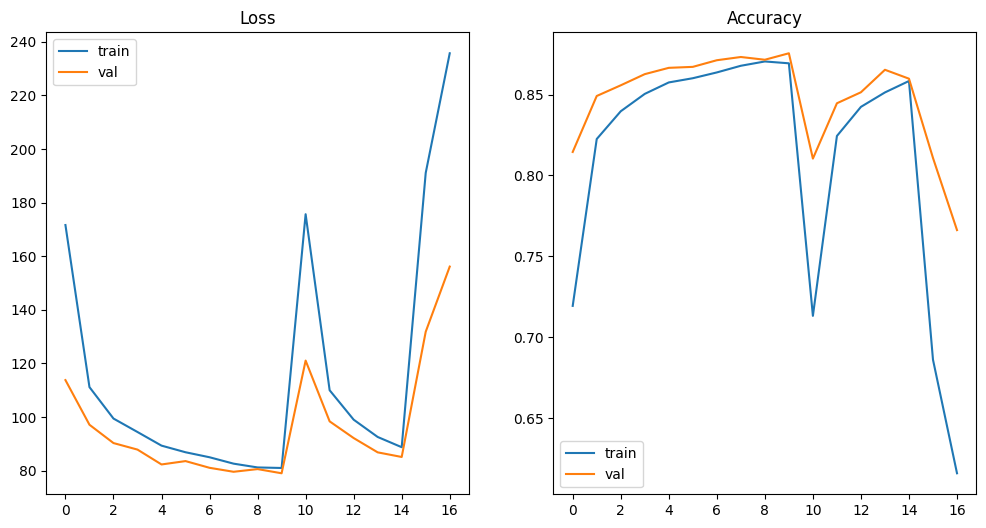

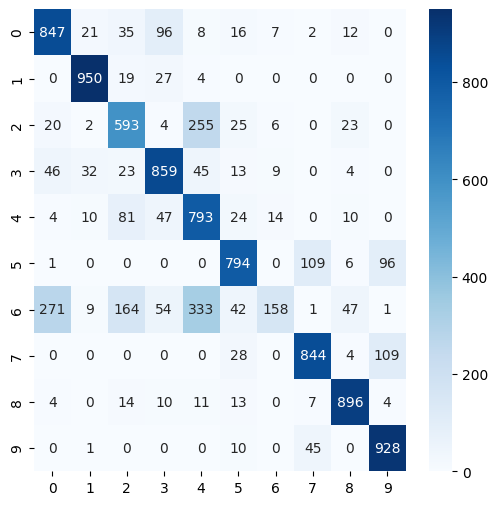

In [55]:
from tqdm import tqdm
import pickle
epochs = 10
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
base_lr = 0.005
loss = CrossEntropyLoss()
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for i in range(4):
    model = get_model3()
    optimizer = Adam(learning_rate=base_lr * 2**-i)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, loss)
        val_loss, val_acc, val_f1, y_pred_all, y_true_all = evaluate(model, val_loader, loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
            f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0 
        else:
            early_stop_counter += 1 
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
                
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model = model
        best_model_name = 'model_2'
        
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
    plot_confusion_matrix(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
    
best_model.set_mode(Mode.EVALUATION)

saved_params = {}
ctr = 0
for layer in best_model.layers:
    if isinstance(layer, FullyConnectedLayer):
        weights, biases = layer.weight, layer.bias
        saved_params[ctr] = {'weights': weights, 'biases': biases}
    elif isinstance(layer, BatchNormalizationLayer):
        running_mean, running_var = layer.running_mean, layer.running_var
        gamma, beta = layer.gamma, layer.beta
        saved_params[ctr] = {'running_mean': running_mean, 'running_var': running_var, 'gamma': gamma, 'beta': beta}
    else:
        saved_params[ctr] = None
    ctr += 1
    
# with open('best_model.pkl', 'wb') as f:
with open('model_1905052.pkl', 'wb') as f:
    pickle.dump(saved_params, f)

In [56]:
print("Best Model: ", {best_model_name})
print("Best Model Val F1 Score: ", {best_val_f1})

Best Model:  {'model_2'}
Best Model Val F1 Score:  {0.87795928935489}


In [57]:
with open('best_model.pkl', 'rb') as f:
    saved_params = pickle.load(f)

if best_model_name == 'model_1': best_model = get_model1()
elif best_model_name == 'model_2': best_model = get_model2()
else: best_model = get_model3()
    
ctr = 0
for layer in best_model.layers:
    if isinstance(layer, FullyConnectedLayer):
        layer.weight, layer.bias = saved_params[ctr]['weights'], saved_params[ctr]['biases']
    elif isinstance(layer, BatchNormalizationLayer):
        layer.running_mean, layer.running_var = saved_params[ctr]['running_mean'], saved_params[ctr]['running_var']
        layer.gamma, layer.beta = saved_params[ctr]['gamma'], saved_params[ctr]['beta']
    ctr += 1
    
model.set_mode(Mode.EVALUATION)

y_pred_all = []
y_true_all = []

for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.numpy(), y_batch.numpy()
    y_pred = best_model.forward(X_batch)
    y_pred_all.append(y_pred)
    y_true_all.append(y_batch)
    
y_pred_all = np.concatenate(y_pred_all)
y_true_all = np.concatenate(y_true_all)

test_acc = accuracy_score(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1))
test_f1 = f1_score(np.argmax(y_true_all, axis=1), np.argmax(y_pred_all, axis=1), average='macro')
print(f'Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')

Test Accuracy: 0.8552, Test F1: 0.8555
